In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

This code has been provided by ChatGPT version 3.5 using the following prompt:

"Provide me a code for the triangular lattice Ising model that includes only first neighbour interactions and is based on the following implementation for the square lattice..."

The implementation provided to ChatGPT is the class "IsingMC_Metropolis", defined in the notebook "solution_week7.ipynb". The first version provided had an incorrect way to access the neighbour points considered for each lattice site. We had to ask for modifying this to obtain a (hopefully) correct implementation.

# Monte Carlo simulation of the classical 2D Ising model (triangular version)

We want to simulate the classical Hamiltonian $H=-J \sum \limits_{\langle i,j\rangle} s_i s_j$ via the Metropolis algorithm. We start with an initial spin-configuration, which we can e.g. choose as all spins up. In each step of the Markov chain, a random site $i$ is chosen, and the next configuration is obtained by flipping spin $s_i$ with probability $min[1,e^{-\frac{\Delta E}{ T}}]$ ($k_B=1$). We start by writing a class containing the basic steps of the Markov chain. In particular, we will need the following member functions:

- **update_probabilities**:
A Markov chain is computationally expensive, as typically a large number of steps is required to compute observables with reasonable accuracy. One of the expensive parts lies in computing the exponential $e^{-\frac{\Delta E}{T}}$ in each step. Convince yourself that $\Delta E$ can only take 5 discrete values, $\Delta E= 2Js_i h_i$, where $h_i =\sum_{\langle i, j\rangle} s_j$. Then, we can reduce the computational cost by defining the member variable self.mrt_prob which consists of the pre-computed exponentials for each of the 5 values that $\Delta E$ can take. For the square lattice we completed the member function 'update_probabilities' to set mrt_prob to the 5 possible values of $e^{-\frac{\Delta E}{T}}$. Now, for the triangular lattice, we have to consider that there are six nearest neighbours instead of 4 and compute all the probabilities.

- **set_temperature**:
(Re-)sets the temperature self.T (probabilities mrt_prob need to be updated when T is set or changed!)

- **reset_spins**:
Sets the spins (array self.spins) to the initial configuration, which we here choose as all spins up. Keep in mind that we want to calculate the magnetization $\langle |m| \rangle=|1.0/L^2 \langle \sum_i s_i \rangle|$. For this, it is useful to keep track of the quantity $M=\sum_i s_i$ (member variable self.M) during the Metropolis algorithm. Set the initial value of $M$ in **reset_spins**.

- **mrt_step**:
Performs one step of the Markov chain. Keep in mind to update self.M as well.

- **mrt_sweep**:
Performs one Monte Carlo sweep, consisting of $L*L$ steps (note: we can keep the definition of a sweep to be the same as for the square lattice. We are essentially inserting our triangular lattice into a square lattice with size L by exploiting the periodicity of the triangular structure).

In [ ]:
import numpy as np
import random

class IsingMC_Metropolis:
    def __init__(self, length, temperature=0.):
        self.spins = np.ones((length,length),dtype=int) # 2D array of spins, corresponds to the current configuration
        self.L = length
        self.T = temperature
        self.M = length * length # magnetization, we start with all spins up
        self.mrt_prob = None
        self.update_probabilities()

    def update_probabilities(self):
        '''Tabularize the probabilities using self.mrt_prob so we don't have to recompute them'''
        if self.T != 0.:
            # Ising acceptance probabilities
            # Access using the index 6 + s_i * h_i
            self.mrt_prob = np.array([np.exp(12. / self.T), 0., np.exp(8. / self.T), 0., np.exp(4. / self.T), 0., 1., 0.,
                                      np.exp(-4. / self.T), 0., np.exp(-8. / self.T), 0., np.exp(-12. / self.T)])
        else:
            # Ising acceptance probabilities
            # Access using the index s_i * h_i
            self.mrt_prob = np.array([1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.])

    def set_temperature(self, temperature):
        '''Set temperature and update the probabilities'''
        self.T = temperature
        self.update_probabilities()

    def reset_spins(self):
        '''Reset the spins to the all-up state'''
        self.spins.fill(1)
        self.M = self.L * self.L

    def mrt_step(self):
        '''Perform one update step using single spin Metropolis'''
        index1 = random.randint(0, self.L-1)
        index2 = random.randint(0, self.L-1)

        # Neighbors of triangular lattice with periodic boundary conditions
        # We have defined the triangular lattice as a square lattice with left diagonals in each "square", connecting the top left corner
        # of each square with the bottom right corner
        if index1 == self.L-1 and index2 == 0: # top right corner site
            neighbors = [((index1-1)%self.L, index2), ((index1+1)%self.L,index2), (index1, (index2+1)%self.L), (index1, (index2-1)%self.L),
                         (index1,index2),(index1,index2)]
        elif index1 == 0 and index2 == self.L-1: # bottom left corner site
            neighbors = [((index1-1)%self.L, index2), ((index1+1)%self.L,index2), (index1, (index2+1)%self.L), (index1, (index2-1)%self.L),
                         (index1,index2),(index1,index2)]
        elif index1 == 0 and index2 != self.L-1: # Top boundary excluding top right corner site
            neighbors = [((index1-1)%self.L, index2), ((index1+1)%self.L,index2), (index1, (index2+1)%self.L), (index1, (index2-1)%self.L),
                         (self.L-1-index2, self.L-1),((index1+1)%self.L, (index2+1)%self.L)]
        elif index1 != self.L-1 and index2 == 0: # Left boundary excluding bottom left corner site
            neighbors = [((index1-1)%self.L, index2), ((index1+1)%self.L,index2), (index1, (index2+1)%self.L), (index1, (index2-1)%self.L),
                         (self.L-1, self.L-1-index1),((index1+1)%self.L, (index2+1)%self.L)]
        elif index1 == self.L-1 and index2 > 0: # bottom boundary excluding bottom left corner site
            neighbors = [((index1-1)%self.L, index2), ((index1+1)%self.L,index2), (index1, (index2+1)%self.L), (index1, (index2-1)%self.L),
                         (index1-1, index2-1),(self.L-1-index2, 0)]
        elif index1 > 0 and index2 == self.L-1: # right boundary excluding top right corner site
            neighbors = [((index1-1)%self.L, index2), ((index1+1)%self.L,index2), (index1, (index2+1)%self.L), (index1, (index2-1)%self.L),
                         (index1-1, index2-1),(0, self.L-1-index1)]
        else: # ALL OTHER SITES (BULK SITES)
            neighbors = [((index1-1)%self.L, index2), ((index1+1)%self.L,index2), (index1, (index2+1)%self.L), (index1, (index2-1)%self.L),
                         (index1-1, index2-1),(index1+1, index2+1)]

        sihi = self.spins[index1][index2] * sum(self.spins[i][j] for i,j in neighbors)
        if self.mrt_prob[sihi + 6] > random.random():
            self.spins[index1][index2] *= -1  # flip
            self.M += 2. * self.spins[index1][index2]  # track magnetization

        ''' CHAT GPT CODE
        if index1 % 2 == 0:
            neighbors = [((index1-1)%self.L, index2), ((index1+1)%self.L, index2), (index1, (index2+1)%self.L), (index1, (index2-1)%self.L)]
        else:
            neighbors = [((index1-1)%self.L, index2), ((index1+1)%self.L, index2), (index1, (index2+1)%self.L), ((index1+1)%self.L, (index2-1)%self.L)]

        sihi = self.spins[index1][index2] * sum(self.spins[i][j] for i, j in neighbors)
        if self.mrt_prob[sihi + 4] > random.random():
            self.spins[index1][index2] *= -1  # flip
            self.M += 2. * self.spins[index1][index2]  # track magnetization
        '''

    def mrt_sweep(self):
        '''Perform an update sweep consisting of L*L steps using single spin Metropolis'''
        for i in range(self.L*self.L):
            self.mrt_step()



### Simulation parameters
Now we define the parameters of our simulation. We'll use a very high number of samples and measure after each single-spin update. This highlights the properties of the Metropolis algorithm better. Typically you would perform a few uncorrelating updates between successive samples.

## Step 1: Thermalization analysis
We start in the M=1 state and relax to different temperatures, sampling the order parameter after each Metropolis update. From that sampled data we calculate averages that take a growing number of samples into account. Note that this data is contaminated by the initial values, so we're probably underestimating the relaxation speed. Observing the convergence of these averages, we can reason about the equilibration dynamics at different temperatures.

In [ ]:
L = 20
dt = 0.1
num_updates = L * L * 200

sys = IsingMC_Metropolis(L)
temperatures = np.arange(1., 6.0, dt)
data = []
for t in temperatures:
    mag_data = []
    sys.reset_spins()
    sys.set_temperature(t)
    for update in range(num_updates):
        sys.mrt_step()
        mag_data.append(np.abs(sys.M) / (sys.L * sys.L))
    data.append(mag_data)

In [ ]:
print("Calculating averages...")
averages = []
count = 0
for dataset in data:
    current = []
    for i in range(1,len(dataset),L*L):                 # we group the measurements in units of sweeps
        current.append(np.mean(dataset[:i]))
    averages.append(np.array(current))
print("Done")

Calculating averages...
Done


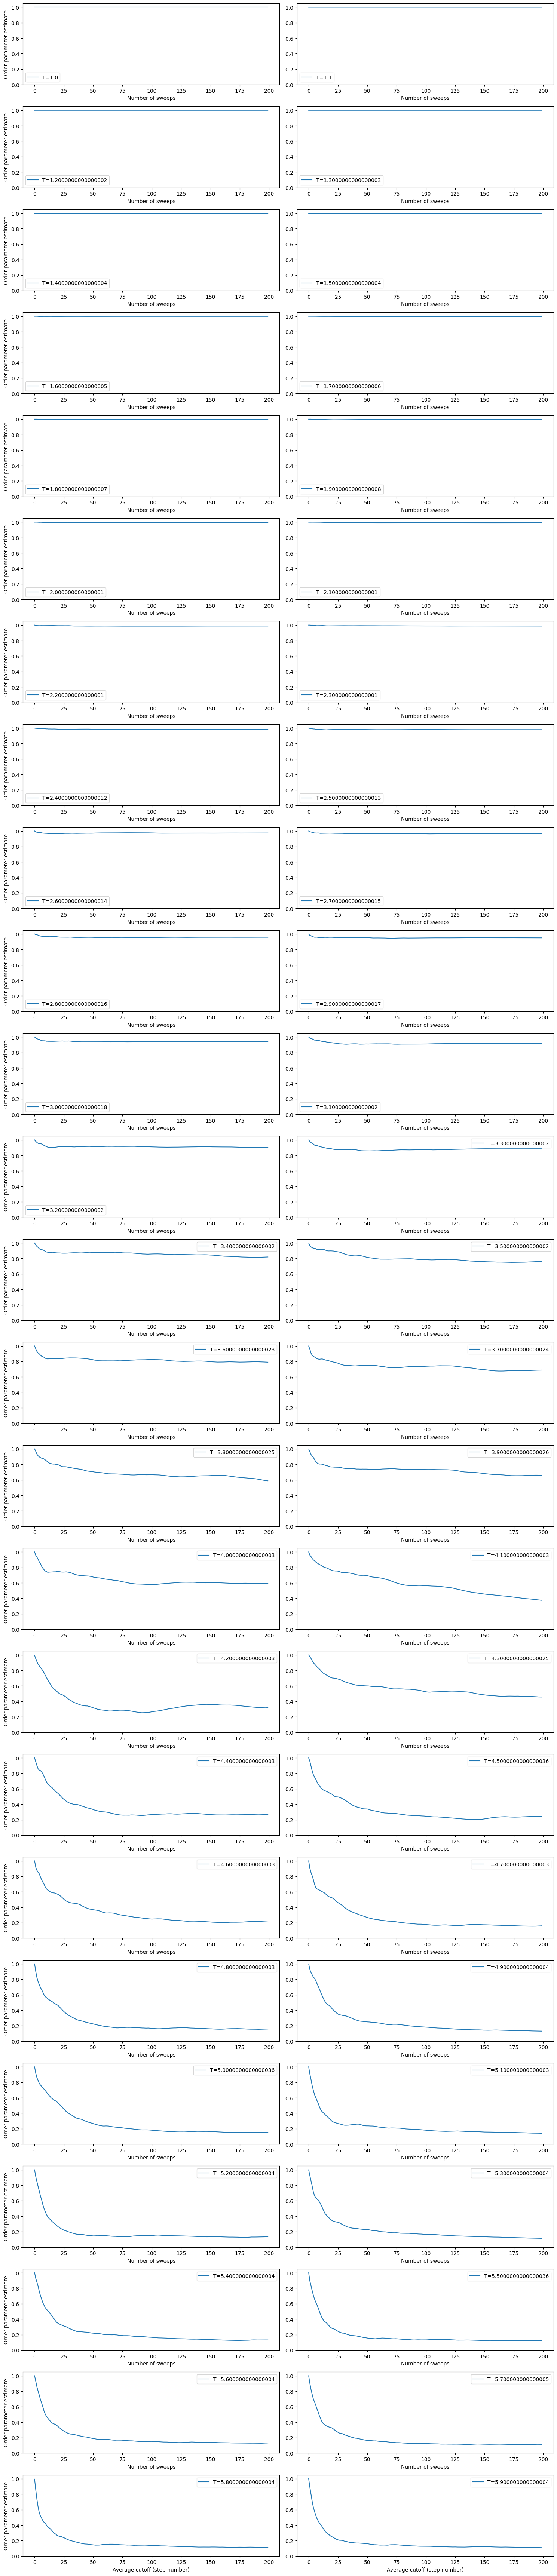

In [ ]:
fig, axs = plt.subplots(25, 2, figsize=(15,69))
for i in range(25):
    axs[i,0].plot(averages[2*i], label=f"T={temperatures[2*i]}")
    axs[i,0].legend()
    axs[i,0].set_ylim([0.,1.05])
    axs[i,0].set_ylabel("Order parameter estimate")
    axs[i,0].set_xlabel("Number of sweeps")
    axs[i,1].plot(averages[2*i+1], label=f"T={temperatures[2*i+1]}")
    axs[i,1].legend()
    axs[i,1].set_ylim([0.,1.05])
    axs[i,1].set_xlabel("Number of sweeps")

axs[24,0].set_xlabel("Average cutoff (step number)");
axs[24,1].set_xlabel("Average cutoff (step number)");
plt.tight_layout()


### Interpretation:
Typically, we seem to be good at an x-axis value of 100 sweps (less sweeps seem to be good for $T<3.0$, but we consider a value that is okay also for the other side of the transition).

We should, however, have a closer look at the critical region, i.e. temperatures between 3.2 and 4.0

In [ ]:
L = 20
dt = 0.1
num_updates = L*L*1000

sys = IsingMC_Metropolis(L)
temperatures = np.arange(3.2,4.0,dt)
data = []
for t in temperatures:
    mag_data = []
    sys.reset_spins()
    sys.set_temperature(t)
    for update in range(num_updates):
        sys.mrt_step()
        mag_data.append(np.abs(sys.M)/(sys.L*sys.L))
    data.append(mag_data)

In [ ]:
print("Calculating averages...")
averages = []
count = 0
for dataset in data:
    current = []
    for i in range(1,len(dataset),L*L):           # we group the measurements in units of sweeps
        current.append(np.mean(dataset[:i]))
    averages.append(np.array(current))
print("Done")

Calculating averages...
Done


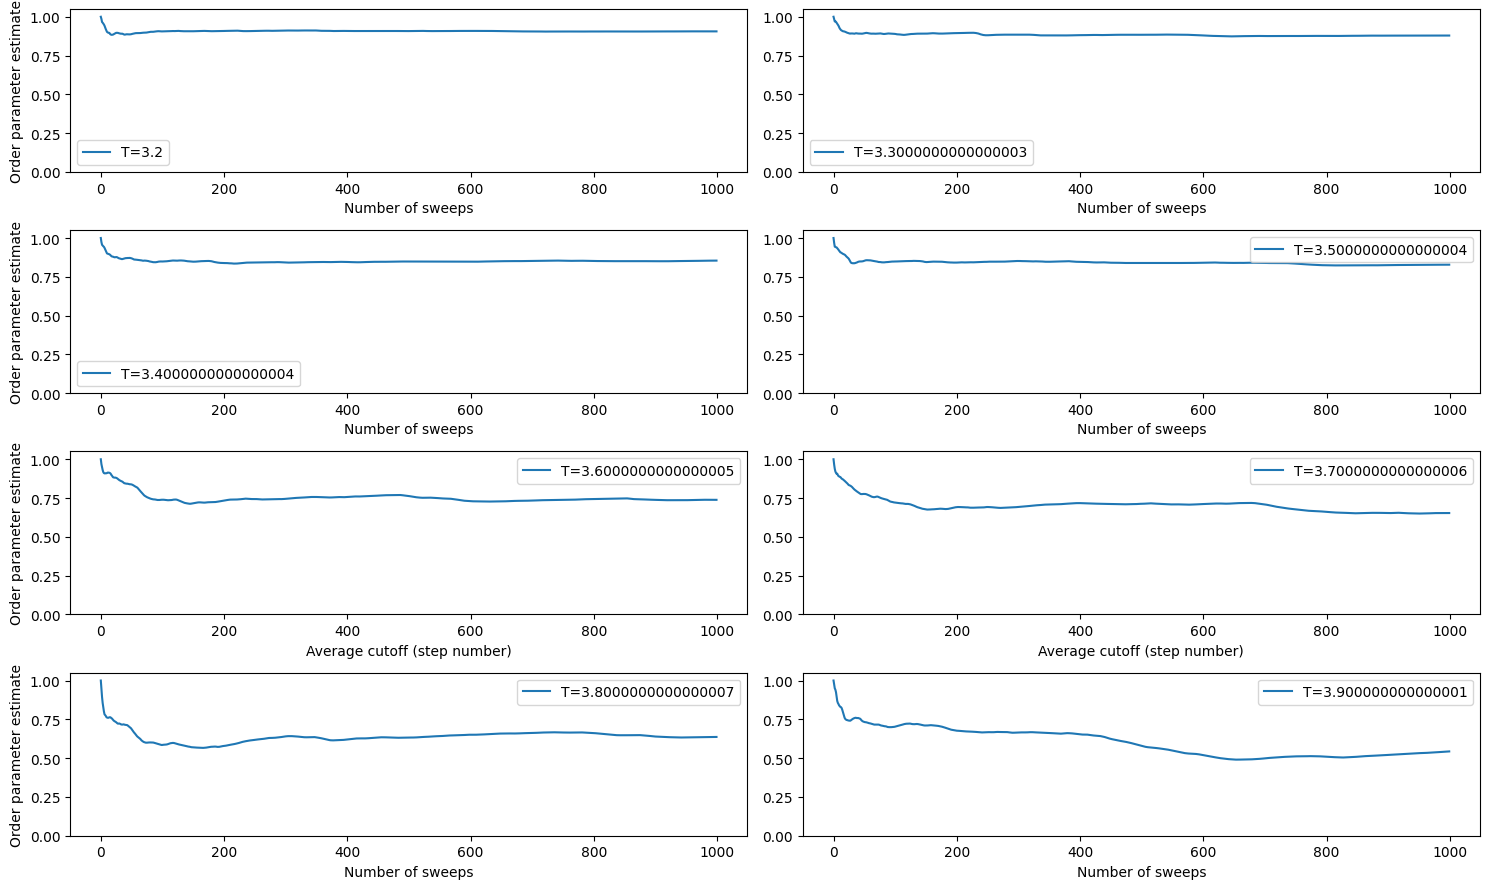

In [ ]:
fig, axs = plt.subplots(4, 2, figsize=(15,9))
for i in range(4):
    axs[i,0].plot(averages[2*i], label=f"T={temperatures[2*i]}")
    axs[i,0].legend()
    axs[i,0].set_ylabel("Order parameter estimate")
    axs[i,0].set_ylim([0.,1.05])
    axs[i,0].set_xlabel("Number of sweeps")
    axs[i,1].plot(averages[2*i+1], label=f"T={temperatures[2*i+1]}")
    axs[i,1].legend()
    axs[i,1].set_ylim([0.,1.05])
    axs[i,1].set_xlabel("Number of sweeps")
axs[2,0].set_xlabel("Average cutoff (step number)");
axs[2,1].set_xlabel("Average cutoff (step number)");
plt.tight_layout()

### Interpretation:
Close to the critical region, we seem to need about 500 sweeps to relax.

## Step 2: Simulation
We use the above observations to run simulations at different temperatures and calculate the order parameter. We take 2^16 samples, so we can easily bin the data.

### Simulation parameters
Now we define the parameters of our simulation. We'll use a very high number of samples and measure after each single-spin update. This highlights the properties of the Metropolis algorithm better. Typically you would perform a few uncorrelating updates between successive samples.

In [ ]:
#temperatures at which we sample
#finer graining around the critical temperature; this is where the money is!
temps_low = np.arange(1.0,3.2,0.1)
temps_crit = np.arange(3.2,4.0,0.02)
temps_high = np.arange(4.0,6.,0.1)
temperatures = np.concatenate((temps_low,temps_crit,temps_high))

#number of relaxation steps we want to perform (different for critical and non critical region)
def relaxation_sweeps(temperature):
    if temperature < 3.2 or temperature > 4.0:
        return 100
    else:
        return 500

#number of samples we take
num_samples = 2**16

### Simulation
Apart from the order parameter, we also measure the actual magnetization, which should be zero for all temperatures. This takes several minutes to run. Implement here the Metropolis algorithm for each temperature including relaxation sweeps in order to equilibrate the system. After thermalization, collect the magnetization and the absolute value of the magnetization. Save the complete collection of the measurements in
m_abs_data=[m_abs_data_T_1, ...m_abs_data_T_N], m_data=[m_data_T_1, ...m_data_T_N], where m_abs_data_T_i (m_data_T_i) correspond to the list of measurements taken for temperature T_i.

In [ ]:
sys.reset_spins()

m_abs_data = []
m_data = []


for temperature in temperatures:
    print(f"temperature: {temperature:.2f}")
    # implement the algorithm here using the class instance sys


    sys.set_temperature(temperature)
    #relaxation
    rlx_sweeps = relaxation_sweeps(temperature)
    for rlx_step in range(rlx_sweeps):
        sys.mrt_sweep()
    #sampling
    m_abs_samples = []
    m_samples = []
    for smp_step in range(num_samples):
        sys.mrt_step()
        m_samples.append(sys.M/(sys.L**2))
        m_abs_samples.append(np.abs(sys.M)/(sys.L**2))
    m_abs_data.append(m_abs_samples)
    m_data.append(m_samples)

temperature: 1.00
temperature: 1.10
temperature: 1.20
temperature: 1.30
temperature: 1.40
temperature: 1.50
temperature: 1.60
temperature: 1.70
temperature: 1.80
temperature: 1.90
temperature: 2.00
temperature: 2.10
temperature: 2.20
temperature: 2.30
temperature: 2.40
temperature: 2.50
temperature: 2.60
temperature: 2.70
temperature: 2.80
temperature: 2.90
temperature: 3.00
temperature: 3.10
temperature: 3.20
temperature: 3.22
temperature: 3.24
temperature: 3.26
temperature: 3.28
temperature: 3.30
temperature: 3.32
temperature: 3.34
temperature: 3.36
temperature: 3.38
temperature: 3.40
temperature: 3.42
temperature: 3.44
temperature: 3.46
temperature: 3.48
temperature: 3.50
temperature: 3.52
temperature: 3.54
temperature: 3.56
temperature: 3.58
temperature: 3.60
temperature: 3.62
temperature: 3.64
temperature: 3.66
temperature: 3.68
temperature: 3.70
temperature: 3.72
temperature: 3.74
temperature: 3.76
temperature: 3.78
temperature: 3.80
temperature: 3.82
temperature: 3.84
temperatur

### Sanity check
Let's have a quick look at the order parameter to check if we get results in agreement with our expectation.

Text(0, 0.5, 'Order Parameter')

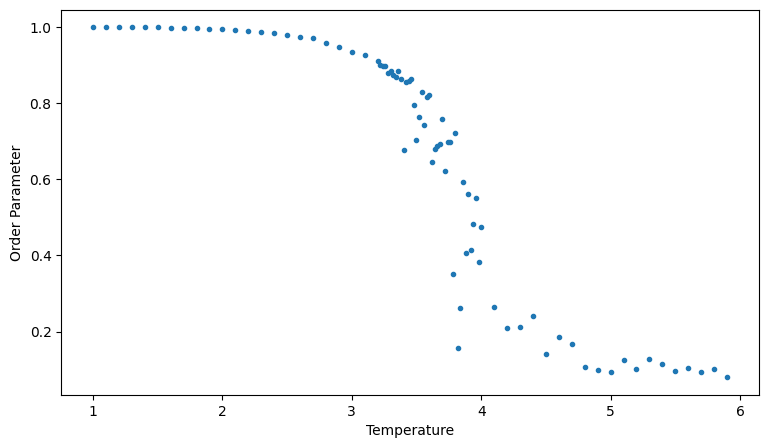

In [ ]:
%matplotlib inline
ops = []
for opd in m_abs_data:
    ops.append(np.mean(opd))
fig= plt.figure(figsize=(9,5))
plt.plot(temperatures,ops,'.')
plt.xlabel("Temperature")
plt.ylabel("Order Parameter")

(-1.05, 1.05)

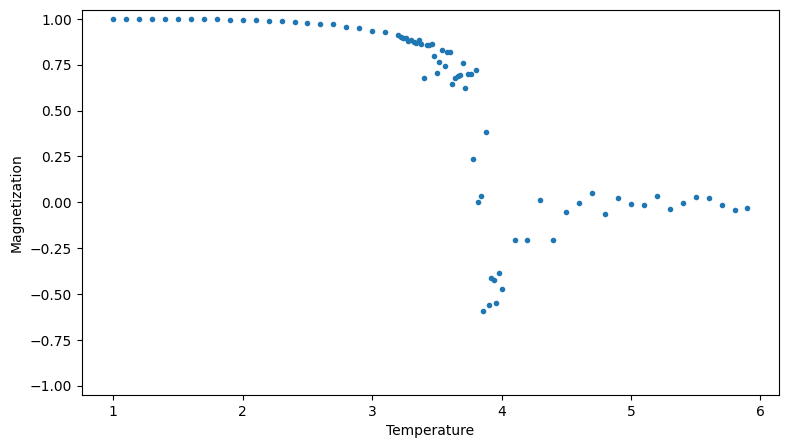

In [ ]:
ms = []
for md in m_data:
    ms.append(np.mean(md))
fig= plt.figure(figsize=(9,5))
plt.plot(temperatures,ms,'.')
plt.xlabel("Temperature")
plt.ylabel("Magnetization")
plt.ylim([-1.05,1.05])

The plots of the parameter order $|M|$ and the magnetization seem to confirm a critical temperature around 3.6, as expected for the triangular lattice.